# Modeling!

> For this project, we will be creating implementations of a Support Vector Machine (SVM), Boosted Decision Trees (BDT--> Adaboost and Gradient Boost), Random Forest, and Naive Bayes to classify the data. We will then compare the performance of the two highest-performing models and select the best one for our final model.

## A Foreword on Scoring...

- For the purposes of this project, we will use accuracy, precision, recall, and F1-scores to measure the predictive power and utility of our machine learning algorithms. 

- Due to the nature of the problem, there isn't a large incentive to value one of these metrics over the others. For example, if we were trying to predict whether or not a patient had a heart attack, we would want to minimize the number of false negatives (i.e. predicting that a patient did not have a heart attack when they actually did). 

- In this case, however, both false negatives and false positives have relatively little impact on the outcome of the problem. Therefore, we will use accuracy as our primary metric for evaluating the performance of our models.

- We will also use the ROC curve to visualize the tradeoff between the true positive rate and the false positive rate.

- Finally, in the case of a close tie, we will err towards choosing a model that is more sensitive to the majority class (i.e. the model that predicts more false positives). Allowing conspiracy and misinformation to pass for real philosophy is arguably (hah) a more serious problem than allowing real philosophy to be mislabeled as conspiracy or misinformation.

## Imports

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import (confusion_matrix, auc,
                             classification_report, ConfusionMatrixDisplay,
                            roc_auc_score, roc_curve, RocCurveDisplay)

## Read in Data

In [2]:
df = pd.read_csv('data/model_data.csv')
df.head()

,conspiracy,post_words,title_words,000 year ago,01 pdf fr,01 pdf fr 1984,06 01 pdf,06 01 pdf fr,09 26 gmt,09 26 gmt fda,...,zizek,zombi,selftext_neg,selftext_neu,selftext_pos,selftext_compound,title_neg,title_neu,title_pos,title_compound
0,1,57,10,0,0,0,0,0,0,0,...,0,0,0.229,0.635,0.136,-0.4767,0.000,0.748,0.252,0.4019
1,1,235,8,0,0,0,0,0,0,0,...,0,0,0.016,0.922,0.061,0.6808,0.400,0.600,0.000,-0.2500
2,1,62,12,0,0,0,0,0,0,0,...,0,0,0.137,0.748,0.115,0.0772,0.000,1.000,0.000,0.0000
3,1,44,4,0,0,0,0,0,0,0,...,0,0,0.321,0.679,0.000,-0.8860,0.643,0.357,0.000,-0.5574
4,1,21,27,0,0,0,0,0,0,0,...,0,0,0.128,0.734,0.138,0.0258,0.000,0.878,0.122,0.2023


### Train/Test Split

In [3]:
X = df.drop(columns='conspiracy')
y = df['conspiracy']

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Baseline Model

This is established by taking the majority class and predicting that for all data points.

In [101]:
ytrain.value_counts(normalize=True)

1    0.642714
0    0.357286
Name: conspiracy, dtype: float64

So, our baseline model has an accuracy of 64%.

___

# Support Vector Machine

### Default Model

In [5]:
# Must scale the data first!
sc = StandardScaler()
Ztrain = sc.fit_transform(Xtrain)
Ztest = sc.transform(Xtest)

In [6]:
# instantiate the model
svm = SVC()

In [ ]:
# Fit with default parameters
svm.fit(Ztrain, ytrain)

In [177]:
print(svm.score(Ztrain, ytrain))
print(svm.score(Ztest, ytest))

0.9459052589321557
0.8828250401284109


### Hyperparameter Tuning

In [147]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [193]:
# Gridsearch (many things have happened here to arrive at this)
p_grid = {
    'C': [11.222222222],
    'kernel': ['sigmoid'],
    'gamma': ['auto'],
}
gs = GridSearchCV(svm, param_grid=p_grid, cv=2, verbose=1, n_jobs=-1)
gs.fit(Ztrain, ytrain)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [11.222222222], 'gamma': ['auto'],
                         'kernel': ['sigmoid']},
             verbose=1)

In [171]:
gs.best_params_

{'C': 11.222222222, 'gamma': 'auto', 'kernel': 'sigmoid'}

In [172]:
print(gs.score(Ztrain, ytrain))
print(gs.score(Ztest, ytest))

0.9315535929345644
0.8864365971107544


Well, it ain't much, but it's honest work.

___

### SVM Evaluation

#### Confusion Matrix

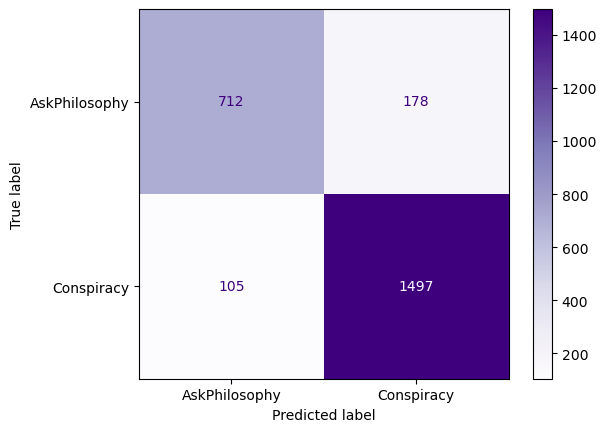

In [173]:
cm = confusion_matrix(ytest, gs.predict(Ztest))
ConfusionMatrixDisplay(cm, display_labels=['AskPhilosophy', 'Conspiracy']
                       ).plot(cmap=sns.color_palette('Purples', as_cmap=True));

#### Classification Report

In [181]:
print(classification_report(ytest, gs.predict(Ztest), target_names=['AskPhilosophy', 'Conspiracy']))

               precision    recall  f1-score   support

AskPhilosophy       0.87      0.80      0.83       890
   Conspiracy       0.89      0.93      0.91      1602

     accuracy                           0.89      2492
    macro avg       0.88      0.87      0.87      2492
 weighted avg       0.89      0.89      0.89      2492



According to the report, the model achieved an overall accuracy of 89%, which means that it correctly classified 89% of the instances in the test dataset.

Looking at the precision scores, we can see that the model correctly predicted r/AskPhilosophy posts 87% of the time, and r/Conspiracy posts 89% of the time. 

For recall, the model correctly identified 80% of the r/AskPhilosophy posts, indicating that it was only right when predicting a post as belonging to "Ask Philosophy" 4/5 times. Understood from the opposite direction, the model has a false negative rate of 20% when predicting the r/AskPhilosophy class.

On the other hand, the model achieved a striking 93% recall on the r/Conspiracy posts. From this, we would say that the model is more sensitive to r/Conspiracy posts than r/AskPhilosophy posts.

Finally, the F1-scores are 83% for r/AskPhilosophy and 91% for r/Conspiracy.

In summary, the model seems to perform well, with high precision and recall scores for both subreddits, as well as an overall accuracy of 89%. The weighted average of precision and recall (F1-score) is also high for both classes, indicating that the model is performing well in terms of both precision and recall.

#### ROC Curve

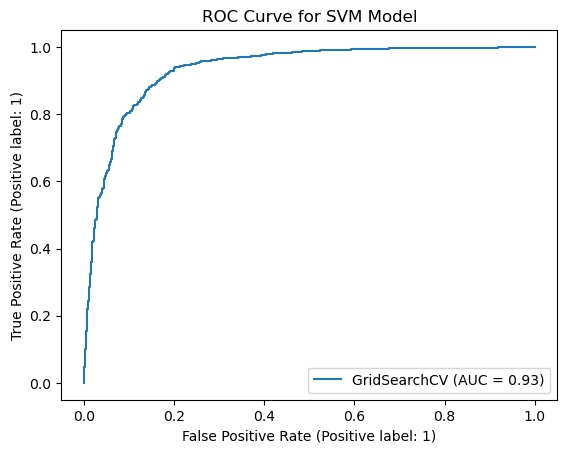

In [210]:
RocCurveDisplay.from_estimator(gs, Ztest, ytest)
plt.title('ROC Curve for SVM Model');

#### Interpretation

An AUC (Area Under the Curve) score of 0.93 suggests that the model has excellent predictive power, with a high true positive rate (TPR) and a low false positive rate (FPR). This means that the model is able to accurately distinguish between positive and negative instances in the dataset. In other words, the model has a high level of sensitivity and specificity, which are desirable qualities for any classification model.

___

# Exploratory Modeling

## AdaBoost

In [8]:
tree = DecisionTreeClassifier(max_depth=10, random_state=42)
ada = AdaBoostClassifier(tree, n_estimators=100, random_state=42,learning_rate=.1, algorithm='SAMME.R')

In [9]:
ada.fit(Xtrain, ytrain)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         random_state=42),
                   learning_rate=0.1, n_estimators=100, random_state=42)

In [10]:
print(ada.score(Xtrain, ytrain))
print(ada.score(Xtest, ytest))

0.9995985547972702
0.7981540930979133


___

## Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(Xtrain, ytrain)

GradientBoostingClassifier()

In [ ]:
print(gb.score(Xtrain, ytrain))
print(gb.score(Xtest, ytest))

0.80228823765556
0.7776886035313002


### Grid Search

In [ ]:
pgrid = {
    'learning_rate': [1, 1.5, 2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7]
}

gb = GradientBoostingClassifier(random_state=222)
gs = GridSearchCV(gb, pgrid, cv=5, n_jobs=6, verbose=1)

In [ ]:
# Fit the gridsearch
# gs.fit(Xtrain, ytrain)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=222),
             n_jobs=6,
             param_grid={'learning_rate': [1, 1.5, 2],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

In [ ]:
# gs.best_params_

{'learning_rate': 1, 'max_depth': 3, 'n_estimators': 300}

In [11]:
gb = GradientBoostingClassifier(learning_rate=1.5, max_depth=3, n_estimators=300, random_state=222)
gb.fit(Xtrain, ytrain)

GradientBoostingClassifier(learning_rate=1.5, n_estimators=300,
                           random_state=222)

In [ ]:
# Score the gridsearch
print(gs.score(Xtrain, ytrain))
print(gs.score(Xtest, ytest))

0.962665596146126
0.8575441412520064


### Best Model

In [ ]:
params = {
    'learning_rate': 1,
    'max_depth': 3,
    'n_estimators': 500
}
gb = GradientBoostingClassifier(**params)
gb.fit(Xtrain, ytrain)
print(gb.score(Xtrain, ytrain))
print(gb.score(Xtest, ytest))

0.9832396627860297
0.8539325842696629


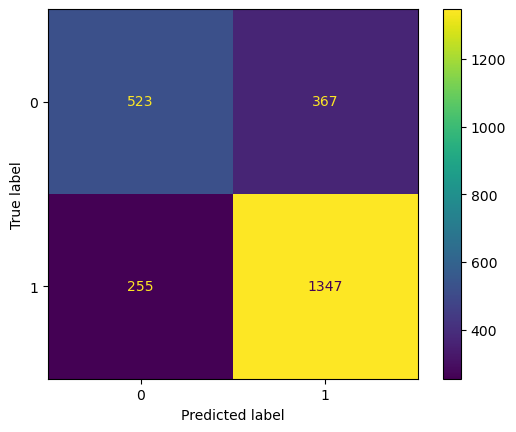

In [ ]:
# Confusion Matrix
cm = confusion_matrix(ytest, ada.predict(Xtest))
ConfusionMatrixDisplay(cm, display_labels=ada.classes_).plot();

___

## Random Forest

In [12]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=3000)

In [13]:
rf.fit(Xtrain, ytrain)
print(rf.score(Xtrain, ytrain))
print(rf.score(Xtest, ytest))

0.9995985547972702
0.8591492776886035


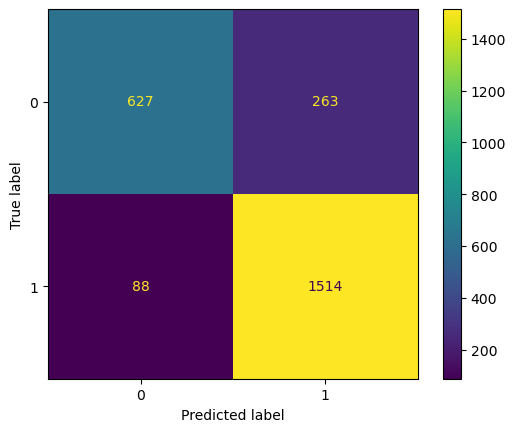

In [141]:
# Confusion Matrix
cm = confusion_matrix(ytest, rf.predict(Xtest))
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot();

___

# Naive Bayes

In [14]:
# Have to drop these columns because of their negative values!
X_nb_train = Xtrain.drop(columns=['title_compound', 'selftext_compound'])
X_nb_test = Xtest.drop(columns=['title_compound', 'selftext_compound'])

In [15]:
nb = MultinomialNB()
nb.fit(X_nb_train, ytrain)
print(nb.score(X_nb_train, ytrain))
print(nb.score(X_nb_test, ytest))

0.9098755519871538
0.8860353130016051


### NB Evaluation

#### Confusion Matrix

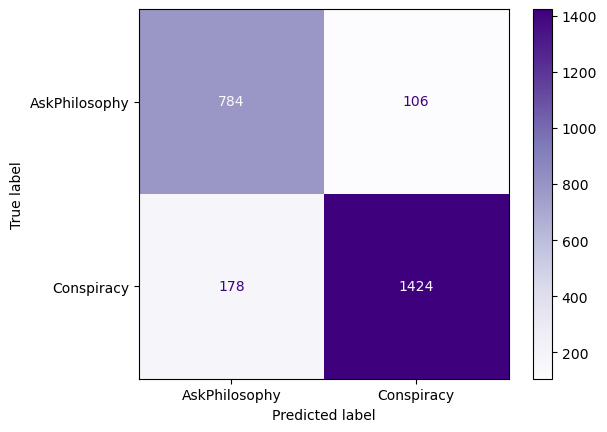

In [213]:
cm = confusion_matrix(ytest, nb.predict(X_nb_test))
ConfusionMatrixDisplay(cm, display_labels=['AskPhilosophy', 'Conspiracy']
                       ).plot(cmap=sns.color_palette('Purples', as_cmap=True));

#### Classification Report

In [214]:
print(classification_report(ytest, nb.predict(X_nb_test), target_names=['AskPhilosophy', 'Conspiracy']))

               precision    recall  f1-score   support

AskPhilosophy       0.81      0.88      0.85       890
   Conspiracy       0.93      0.89      0.91      1602

     accuracy                           0.89      2492
    macro avg       0.87      0.88      0.88      2492
 weighted avg       0.89      0.89      0.89      2492



#### Interpretation:

This model has an overall accuracy of 89%, which is equal to the SVM model. The recall score is higher for AskPhilosophy, but lower for Conspiracy. The F1-scores are similar, with a slight edge to the NB model.

Both models achieve an overall F1-score of 0.89, which is a good score. Honestly, either one of these models would be a good choice for our final model.


#### ROC Curve

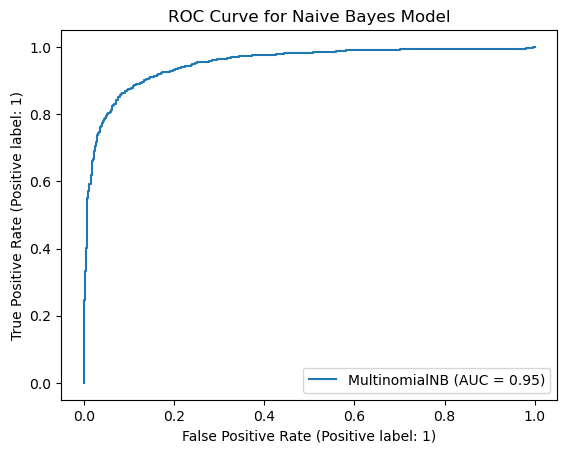

In [215]:
RocCurveDisplay.from_estimator(nb, X_nb_test, ytest)
plt.title('ROC Curve for Naive Bayes Model');

#### Interpretation

The AUC score of 0.95 is very high, indicating that the model has excellent predictive power. The model has a high true positive rate (TPR) and a low false positive rate (FPR), barely edging out the SVM for the best model along this metric.

---

# Production Model

For the final model, I've decided to use the SVM model. It has accuracy equal to the NB Model, but a higher recall score for Conspiracy, which is the class we want to be more sensitive to. 

In [ ]:
# Must scale the data first!
sc = StandardScaler()
Ztrain = sc.fit_transform(Xtrain)
Ztest = sc.transform(Xtest)

In [7]:
svm = SVC(C=11.222222222, gamma='auto', kernel='sigmoid')
svm.fit(Ztrain, ytrain)

SVC(C=11.222222222, gamma='auto', kernel='sigmoid')

In [ ]:
print(svm.score(Ztrain, ytrain))
print(svm.score(Ztest, ytest))

## Concluding Remarks:

After analyzing online discourse in two different subreddits, r/AskPhilosophy and r/Conspiracy, through natural language processing and machine learning algorithms, it's clear that there are significant differences in the language used by these communities. The project successfully demonstrated the potential for using data science techniques to classify posts on Reddit based on their language, and the results have the potential to be useful for moderators and researchers in these subreddits. By identifying language use trends, moderators can more easily spot off-topic or rule-violating posts, while researchers can gain insights into the types of argumentative structures used to advocate for ideas online.

The project's final model, a Support Vector Machine using a sigmoid kernel implementation, had an overall accuracy of roughly 90% with a 93% sensitivity to the Conspiracy class, making it a promising tool for identifying posts that may warrant further scrutiny. However, it's worth noting that the project's scope was quite broad, and more focused analyses could be conducted in the future to delve deeper into online discourse and the types of attitudes represented in these subreddits.

Overall, this project demonstrates the power of natural language processing and machine learning in understanding online discourse, and it's exciting to consider the possibilities for future research in this area. Whether it's analyzing language use trends, identifying off-topic posts, or gaining insights into different communities and their argumentative structures, there's no doubt that data science techniques can provide valuable insights into the online world.

___

## Ensembling

In [16]:
ada

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                         random_state=42),
                   learning_rate=0.1, n_estimators=100, random_state=42)

In [17]:
gb

GradientBoostingClassifier(learning_rate=1.5, n_estimators=300,
                           random_state=222)

In [18]:
rf

RandomForestClassifier(n_estimators=3000, n_jobs=-1, random_state=42)

In [19]:
nb

MultinomialNB()

In [20]:
svm

SVC(C=11.222222222, gamma='auto', kernel='sigmoid')

In [34]:
vc = VotingClassifier(
    estimators=[
        ('ada', ada), 
        ('gb', gb),
        ('rf', rf), 
        ('nb', nb), 
        ('svm', svm)]
    , voting='hard')

In [35]:
Ztrain = abs(sc.fit_transform(Xtrain.drop(columns=['title_compound','selftext_compound'])))
Ztest = abs(sc.transform(Xtest.drop(columns=['title_compound','selftext_compound'])))

In [36]:
vc.fit(Ztrain, ytrain)

/Users/jackvaughan/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                                       random_state=42),
                                                 learning_rate=0.1,
                                                 n_estimators=100,
                                                 random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=1.5,
                                                         n_estimators=300,
                                                         random_state=222)),
                             ('rf',
                              RandomForestClassifier(n_estimators=3000,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('nb', Multinomia

In [37]:
print(vc.score(Ztrain, ytrain))


0.976916900843035


In [38]:
print(vc.score(Ztest, ytest))

0.8936597110754414
